In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp
#import cgl_thalamic as ct
import thal1
from cgl_thalamic import rhs_thal

from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import solve_ivp

import scipy as sp
from scipy.optimize import root,bisect

import copy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
reload(thal1);reload(nm);reload(rp)
nmc = nm.nmCoupling;rsp = rp.Response

# Definitions

## Forcing function

In [3]:
def ff(x,a,om,del1=0):
    return a*np.sin((om+del1)*x)+.2

In [4]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'om':1,'om_fix':1}

pd2 = {'om':1,'amp':1,'om_fix':1}

In [32]:
# default period must be 2*np.pinp.sin(
kws1 = {'var_names':['v','h','r','qt'],
        'rhs':rhs_thal,
        'init':np.array([-.64,0.71,0.25,0,5]),
        'TN':2000,
        'idx':0,
        'model_name':'thalf0',
        'trunc_order':3,
        'recompute_list':[],
        'z_forward':False,
        'i_forward':False,
        'i_bad_dx':False,
        'coupling':thal1.coupling_thal}

kws2 = {'var_names':[],
        'rhs':None,
        'init':None,
        'coupling':None,
        'model_name':'f1',
        'forcing_fn':ff,
        'idx':1,
        'TN':0}

## Reduced rhs

In [33]:
def ct_redu(t,y,eps,system1,del1):
    h = 0
    for i in range(system1.miter):
        h += eps**(i+1)*(system1.h['lam'][i](y))
    h += del1
    return h

## Full rhs

In [34]:
def ct_full(t,y,eps,pd1,pd2,del1,system2):
    out1 = rhs_thal(t,y,pd1,'val',0) + eps*thal1.coupling_thal([*y,system2(t,del1)],pd1,'val',0)
    return np.array(list(out1))

## Phase-locking existence

In [35]:
x = np.linspace(0,2*np.pi,1000)
def pl_exist(eps,del1,system1):
    h = ct_redu(0,x,eps,system1,del1)
    #for i in range(system1.miter):
    #    h += eps_val**(i+1)*(system1.h['lam'][i](x))
    # get all zeros
    
    z1 = x[1:][(h[1:]>0)*(h[:-1]<=0)]
    z2 = x[1:][(h[1:]<0)*(h[:-1]>=0)]
    if eps == 0:
        return -1
        
    if len(z1)+len(z2) > 0:
        return 1
    else:
        return -1

## Get tongue

In [36]:
def get_tongue(del_list,system1,deps=.002,max_eps=.3,min_eps=0):

    ve_exist = np.zeros(len(del_list))
    
    for i in range(len(del_list)):
        print(np.round((i+1)/len(del_list),2),'    ',end='\r')
        eps = min_eps
        while not(pl_exist(eps,del_list[i],system1)+1)\
        and eps <= max_eps:
            eps += deps
        if eps >= max_eps:
            ve_exist[i] = np.nan
        else:
            out = bisect(pl_exist,0,eps+deps,args=(del_list[i],system1))
            ve_exist[i] = out
    print('')
    return del_list,ve_exist

## Full model phase estimate

In [37]:
def get_phase(sol_full,skipn,system1):

    phase1 = np.zeros(len(sol_full.t[::skipn]))
    for i in range(len(sol_full.t[::skipn])):
        d1 = np.linalg.norm(sol_full.y.T[::skipn][i,:4]-system1.lc['dat'],axis=1)
        phase1[i] = np.argmin(d1)/len(system1.lc['dat'])
    return sol_full.t[::skipn],phase1

# Tongue 1:1

## Load response and coupling functions

In [38]:
system11a = rsp(pardict=copy.deepcopy(pd1),**copy.deepcopy(kws1))
system11b = rsp(pardict=copy.deepcopy(pd2),**copy.deepcopy(kws2))

* Loading LC data...
* Loading monodromy...
* Floquet Exponent kappa =-0.023568265867307696
* Computing g symbolic...
* Computing g...
dx=2.13e+00, al=1.00e+00
dx=7.51e-02, al=1.00e+00
dx=4.62e-03, al=1.00e+00
dx=7.32e-04, al=1.00e+00
dx=6.03e-05, al=1.00e+00
dx=3.14e-05, al=1.00e+00
dx=1.20e-04, al=9.09e-01
dx=1.15e-04, al=9.09e-01
dx=9.18e-05, al=9.09e-01
dx=1.40e-04, al=8.26e-01
dx=1.65e-04, al=7.51e-01
dx=2.16e-05, al=7.51e-01
dx=7.47e-06, al=7.51e-01
dx=6.06e-05, al=6.83e-01
dx=7.01e-05, al=6.21e-01
dx=9.30e-05, al=5.64e-01
dx=4.27e-05, al=5.64e-01
dx=3.89e-05, al=5.64e-01
dx=5.88e-05, al=5.13e-01
dx=3.17e-05, al=5.13e-01
dx=7.34e-05, al=4.67e-01
dx=1.61e-04, al=4.24e-01
dx=1.17e-05, al=4.24e-01
dx=4.75e-05, al=3.86e-01
dx=5.84e-05, al=3.50e-01
dx=4.99e-06, al=3.50e-01
dx=1.06e-04, al=3.19e-01
dx=1.36e-05, al=3.19e-01
dx=6.51e-05, al=2.90e-01
dx=7.97e-05, al=2.63e-01
* Computing heterogeneous terms...
* Computing z...
dx=8.84e+00, al=1.00e+00
dx=2.27e-01, al=1.00e+00
dx=2.60e-03, 

In [42]:
a = nmc(system11a,system11b,
        #recompute_list=['p_cglf0','h_cglf0','p_data_cglf0','h_data_cglf0'],
        #recompute_list=recompute_list,
        _n=('om0',1),_m=('om1',1),
        NP=500,NH=500)

* Loading p symbolic...
* Loading p...
* Loading p...
* Loading p...
* Loading p...
* Loading H symbolic...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...
* Loading H thalf0, order=2...
* Loading H thalf0, order=3...


In [43]:
#dtemp = np.linspace(-1,1,51)
d1 = np.linspace(-10,0,30)
#dtemp = np.linspace(-1e-3,1e-3,31)

del_list_11a,ve_list_11a = get_tongue(2**d1,system11a,deps=.001,max_eps=1)
del_list_11b,ve_list_11b = get_tongue(-2**d1,system11a,deps=.001,max_eps=1)

1.0      
1.0      


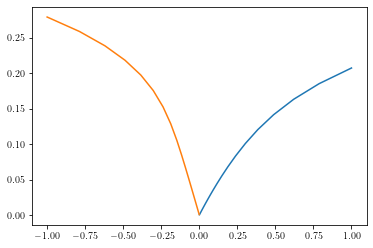

In [44]:
fig,axs = plt.subplots()
axs.plot(del_list_11a,ve_list_11a)
axs.plot(del_list_11b,ve_list_11b)

## Verify with full model

In [26]:
eps11 = .01
del11 = .01
th_init = 0

In [27]:
dt = .02;T=5000
t = np.arange(0,T,dt)

y0 = system11a.lc['dat'][int((th_init/(2*np.pi))*system11a.TN),:]

sol_redu = solve_ivp(ct_redu,[0,t[-1]],[th_init],method='LSODA',t_eval=t,
                     args=(eps11,system11a,del11),rtol=1e-7,atol=1e-7)

sol_full = solve_ivp(ct_full,[0,t[-1]],y0,method='LSODA',
                     t_eval=t,args=(eps11,system11a.pardict,
                                    system11b.pardict,del11,system11b),rtol=1e-6,atol=1e-6)

In [28]:
# fig,axs = plt.subplots()
# axs.plot(t,sol_full.y.T[:,0])
# axs.plot(t,system11b(t))
# axs.set_xlim(t[-1]-100,t[-1])

In [29]:
# estimate phase for each model and compare phase difference
x, phase1 = get_phase(sol_full,skipn=10,system1=system11a)

(0.0, 6.283185307179586)

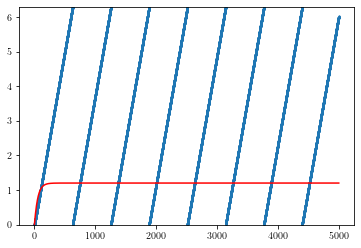

In [30]:
fig,axs = plt.subplots()
forcing_phase = np.mod(a._m[1]*np.linspace(0,x[-1],len(x)),2*np.pi)
y = np.mod(phase1*2*np.pi-a.om*forcing_phase,2*np.pi)
#y = phase1*2*np.pi

axs.scatter(x,y,s=1)
#axs.plot(x,np.mod(forcing_phase,2*np.pi))
axs.plot(t,np.mod(sol_redu.y.T[:,0],2*np.pi),color='red')
#axs.set_xlim(0,100)
axs.set_ylim(0,2*np.pi)

# Tongue 1:2

## Load response and coupling functions

In [14]:
system12a = rsp(pardict=copy.deepcopy(pd1),**copy.deepcopy(kws1))
system12b = rsp(pardict=copy.deepcopy(pd2),**copy.deepcopy(kws2))

* Loading LC data...
* Loading monodromy...
* Floquet Exponent kappa =-0.023568265867307696
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [15]:
a = nmc(system12a,system12b,
        #recompute_list=['p_cglf0','h_cglf0','p_data_cglf0','h_data_cglf0'],
        #recompute_list=recompute_list,
        _n=('om0',1),_m=('om1',2),
        NP=300,NH=300)

* Loading p symbolic...
* Loading p...
* Loading p...
* Loading p...
* Loading H symbolic...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...
* Loading H thalf0, order=2...


In [19]:
d1 = np.linspace(-15,0,20)

del_list_12a,ve_list_12a = get_tongue(2**d1,system12a,deps=.001,max_eps=1)
del_list_12b,ve_list_12b = get_tongue(-2**d1,system12a,deps=.001,max_eps=1)

1.0      
1.0      


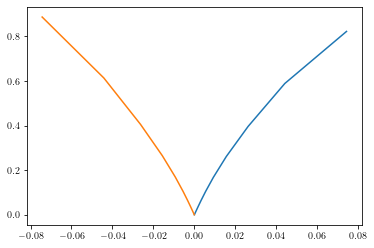

In [20]:
fig,axs = plt.subplots()
axs.plot(del_list_12a,ve_list_12a)
axs.plot(del_list_12b,ve_list_12b)
#axs.set_xscale('symlog')

# Tongue 2:3

## Load coupling functions

In [21]:
system23a = rsp(pardict=copy.deepcopy(pd1),**copy.deepcopy(kws1))
system23b = rsp(pardict=copy.deepcopy(pd2),**copy.deepcopy(kws2))

* Loading LC data...
* Loading monodromy...
* Floquet Exponent kappa =-0.023568265867307696
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [22]:
a = nmc(system23a,system23b,
        #recompute_list=['p_cglf0','h_cglf0','p_data_cglf0','h_data_cglf0'],
        #recompute_list=recompute_list,
        _n=('om0',2),_m=('om1',3),
        NP=300,NH=300)

* Loading p symbolic...
* Loading p...
* Loading p...
* Loading p...
* Loading H symbolic...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...
* Loading H thalf0, order=2...


In [23]:
d1 = np.linspace(-10,0,20,endpoint=False)
#dtemp = np.linspace(-1e-3,1e-3,31)

del_list_23a,ve_list_23a = get_tongue(2**d1,system23a,deps=.005,max_eps=1)
del_list_23b,ve_list_23b = get_tongue(-2**d1,system23a,deps=.005,max_eps=1)

1.0     
1.0     


In [25]:
ve_list_23a

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

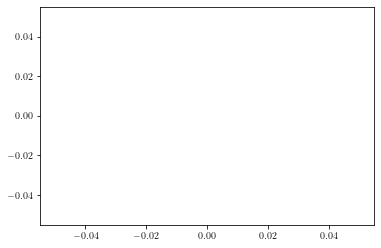

In [24]:
fig,axs = plt.subplots()
axs.plot(del_list_23a,ve_list_23a)
axs.plot(del_list_23b,ve_list_23b)
#axs.set_xscale('symlog')
#axs.set_xscale('log')

# Tongue 1:3

## Load coupling functions

In [26]:
system13a = rsp(pardict=copy.deepcopy(pd1),**copy.deepcopy(kws1))
system13b = rsp(pardict=copy.deepcopy(pd2),**copy.deepcopy(kws2))

* Loading LC data...
* Loading monodromy...
* Floquet Exponent kappa =-0.023568265867307696
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [27]:
a = nmc(system13a,system13b,
        #recompute_list=['p_cglf0','h_cglf0','p_data_cglf0','h_data_cglf0'],
        #recompute_list=recompute_list,
        _n=('om0',1),_m=('om1',3),
        NP=500,NH=500)

* Loading p symbolic...
* Loading p...
* Loading p...
* Computing p...
* Loading H symbolic...
* Computing H thalf0, order=0...
* Computing H thalf0, order=1...
* Computing H thalf0, order=2...


In [87]:
d1 = np.linspace(-9,0,10,endpoint=False)
#dtemp = np.linspace(-1e-3,1e-3,31)

del_list_13a,ve_list_13a = get_tongue(2**d1,system13a,deps=.00002,max_eps=.2)
del_list_13b,ve_list_13b = get_tongue(-2**d1,system13a,deps=.00002,max_eps=.2)

1.0     
1.0     


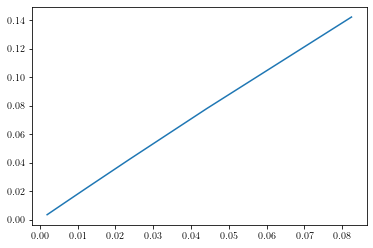

In [90]:
fig,axs = plt.subplots()
axs.plot(del_list_13a,ve_list_13a)
axs.plot(del_list_13b,ve_list_13b)
#axs.set_xscale('symlog')
#axs.set_xscale('log')
#axs.set_xlim(4e-6,2e-5)

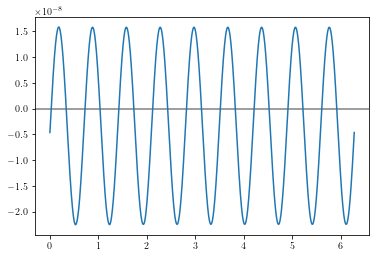

In [63]:
eps = .00000185
x = np.linspace(0,2*np.pi,10000)
h = ct_redu(0,x,eps,system13a,1e-6)

fig,axs = plt.subplots()
axs.axhline(0,0,2*np.pi,color='gray')
axs.plot(x,h)

# Plot

In [96]:
import matplotlib

In [7]:
cmap = matplotlib.colormaps['viridis']
fsize = 12

fig,axs = plt.subplots(figsize=(8,3))

axs.plot(del_list_13a+1/3,ve_list_13a,color=cmap(0),label='1:3',ls='-.')
axs.plot(del_list_13b+1/3,ve_list_13b,color=cmap(0),ls='-.')

axs.plot(del_list_12a+1/2,ve_list_12a,color=cmap(.2),label='1:2',ls='--')
axs.plot(del_list_12b+1/2,ve_list_12b,color=cmap(.2),ls='--')

axs.plot(del_list_23a+2/3,ve_list_23a,color=cmap(.4),label='2:3',ls=':')
axs.plot(del_list_23b+2/3,ve_list_23b,color=cmap(.4),ls=':')

axs.plot(del_list_11+1,ve_list_11,label='1:1',color=cmap(.6))

axs.set_ylim(0,.35)

#axs.set_yscale('log')
axs.set_xlabel(r'$\omega_X/(\omega_f+\delta)$',fontsize=fsize)
axs.set_ylabel(r'$\varepsilon$',fontsize=fsize)

axs.set_xticks([1/3,1/2,2/3,1])
axs.set_xticklabels(['$1{:}3$','$1{:}2$','$2{:}3$','$1{:}1$'],fontsize=fsize)

plt.savefig('../')

NameError: name 'matplotlib' is not defined